In [2]:
import torch
from torch import device
from PIL import Image
import numpy as np
from torchvision import utils as vutils
from matplotlib import pyplot as plt
import sys
sys.path.append('/data/CS470_HnC/retrieval_model/')
sys.path.append('/data/CS470_HnC/cookgan/')
import train_retrieval
import models_retrieval_nobak
import train_cookgan
import models_cookgan
import importlib
importlib.reload(train_retrieval)
importlib.reload(models_retrieval_nobak)
importlib.reload(train_cookgan)
importlib.reload(models_cookgan)

<module 'models_cookgan' from '/data/CS470_HnC/cookgan/models_cookgan.py'>

In [3]:
text_encoder = models_retrieval_nobak.TextEncoder(
    data_dir='/data/CS470_HnC/', text_info='010', hid_dim=300,
    emb_dim=300, z_dim=1024, with_attention=2,
    ingr_enc_type='rnn').eval()
# model = torch.load('/data/CS470_HnC/retrieval_model/wandb/run-20221115_141017-qn8zgvm8/files/00390000.ckpt')['text_encoder']
# text_encoder.load_state_dict(model, strict = False)
text_encoder.load_state_dict(torch.load('/data/CS470_HnC/text_encoder.model'))

food_type = 'salad'
netG = models_cookgan.G_NET(levels=3).eval().requires_grad_(False)
# netG.load_state_dict(torch.load('/data/CS470_HnC/cookgan/wandb/run-20221120_171820-1jnhbhwl/files/180000.ckpt')['netG'])
netG.load_state_dict(torch.load('/data/CS470_HnC/gen_salad_cycleTxt1.0_e300.model'))


<All keys matched successfully>

vocab_inst size = 14556
vocab_ingr size = 1991
(256, 256, 3)


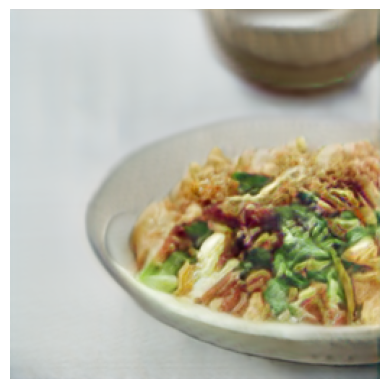

In [4]:
from common import get_title_wordvec, get_ingredients_wordvec, get_instructions_wordvec

def load_dict(file_path):
    with open(file_path, 'r') as f_vocab:
        w2i = {w.rstrip(): i+3 for i, w in enumerate(f_vocab)}
        w2i['<end>'] = 1
        w2i['<other>'] = 2
    return w2i

# load instructions word mapping file, used for model data preprocessing 
word2i = load_dict('/data/CS470_HnC/vocab_inst.txt')
print('vocab_inst size =', len(word2i))

# load ingredients word mapping file, used for model data preprocessing 
ingr2i = load_dict('/data/CS470_HnC/vocab_ingr.txt')
print('vocab_ingr size =', len(ingr2i))

def vectorize(recipe, word2i, ingr2i):
    """data preprocessing, from recipe text to one-hot inputs

    Arguments:
        recipe {dict} -- a dictionary with 'title', 'ingredients', 'instructions'
        word2i {dict} -- word mapping for title and instructions
        ingr2i {dict} -- ingredient mapping

    Returns:
        list -- a list of three tensors [title, ingredients and instructions]
    """    
    title, _ = get_title_wordvec(recipe, word2i) # np.int [max_len]
    ingredients, _ = get_ingredients_wordvec(recipe, ingr2i, permute_ingrs=False) # np.int [max_len]
    instructions, _, _ = get_instructions_wordvec(recipe, word2i) # np.int [max_len, max_len]
    return [torch.tensor(x).unsqueeze(0) for x in [title, ingredients, instructions]]
    
def generate_images(ingredients, batch) :
    title = 'dummy title'
    # print('[DEBUG]', ingredients)
    instructions = 'dummy instructions'

    recipe = {
        'title': title,
        'ingredients': [x.replace(' ', '_') for x in ingredients],
        'instructions': instructions
    }
    title_vec, ingrs_vec, insts_vec = vectorize(recipe, word2i, ingr2i)
    # print(ingrs_vec)
    title_vec = title_vec.repeat(batch, 1)
    ingrs_vec = ingrs_vec.repeat(batch, 1)
    insts_vec = insts_vec.repeat(batch, 1, 1)
    noise = torch.FloatTensor(batch, 100).normal_(0, 1)
    text_feature = text_encoder([title_vec, ingrs_vec, insts_vec])
    
    imgs, _, _ = netG(noise, text_feature)
    img = imgs[2][0].detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    print(img.shape)
    img = (img - img.min()) / (img.max() - img.min())
    return img

# img = generate_images(['flour', 'salt', 'tomato'], 1) # with tomato
img = generate_images(['flour', 'salt'], 1) # without tomato
# img = generate_images(['tender','coating_mix','lettuce','crouton','cheese','salad_dressing'],1)
# img = generate_images(["red_pepper"], 1)
plt.axis('off') # 추가
plt.imshow(img)
plt.savefig("wo_tomato.png", bbox_inches = 'tight', pad_inches = 0) # 추가

vocab_inst size = 14556
vocab_ingr size = 1991
(256, 256, 3)


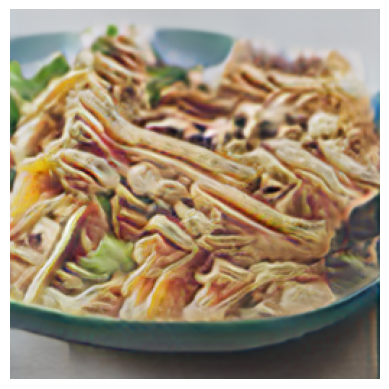

In [36]:
from common import get_title_wordvec, get_ingredients_wordvec, get_instructions_wordvec

def load_dict(file_path):
    with open(file_path, 'r') as f_vocab:
        w2i = {w.rstrip(): i+3 for i, w in enumerate(f_vocab)}
        w2i['<end>'] = 1
        w2i['<other>'] = 2
    return w2i

# load instructions word mapping file, used for model data preprocessing 
word2i = load_dict('/data/CS470_HnC/vocab_inst.txt')
print('vocab_inst size =', len(word2i))

# load ingredients word mapping file, used for model data preprocessing 
ingr2i = load_dict('/data/CS470_HnC/vocab_ingr.txt')
print('vocab_ingr size =', len(ingr2i))

def vectorize(recipe, word2i, ingr2i):
    """data preprocessing, from recipe text to one-hot inputs

    Arguments:
        recipe {dict} -- a dictionary with 'title', 'ingredients', 'instructions'
        word2i {dict} -- word mapping for title and instructions
        ingr2i {dict} -- ingredient mapping

    Returns:
        list -- a list of three tensors [title, ingredients and instructions]
    """    
    title, _ = get_title_wordvec(recipe, word2i) # np.int [max_len]
    ingredients, _ = get_ingredients_wordvec(recipe, ingr2i, permute_ingrs=False) # np.int [max_len]
    instructions, _, _ = get_instructions_wordvec(recipe, word2i) # np.int [max_len, max_len]
    return [torch.tensor(x).unsqueeze(0) for x in [title, ingredients, instructions]]
    
def generate_images(ingredients, batch) :
    title = 'dummy title'
    # print('[DEBUG]', ingredients)
    instructions = 'dummy instructions'

    recipe = {
        'title': title,
        'ingredients': [x.replace(' ', '_') for x in ingredients],
        'instructions': instructions
    }
    title_vec, ingrs_vec, insts_vec = vectorize(recipe, word2i, ingr2i)
    # print(ingrs_vec)
    title_vec = title_vec.repeat(batch, 1)
    ingrs_vec = ingrs_vec.repeat(batch, 1)
    insts_vec = insts_vec.repeat(batch, 1, 1)
    noise = torch.FloatTensor(batch, 100).normal_(0, 1)
    text_feature = text_encoder([title_vec, ingrs_vec, insts_vec])
    
    imgs, _, _ = netG(noise, text_feature)
    img = imgs[2][0].detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    print(img.shape)
    img = (img - img.min()) / (img.max() - img.min())
    return img

# img = generate_images(['flour', 'salt', 'tomato'], 1) # with tomato
img = generate_images(['penne', 'basil', 'salt', 'mozzarella_cheese'], 1) # without tomato
# img = generate_images(['tender','coating_mix','lettuce','crouton','cheese','salad_dressing'],1)
# img = generate_images(["red_pepper"], 1)
plt.axis('off') # 추가
plt.imshow(img)